In [1]:
# As usual, a bit of setup

import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from metropolis_hastings import *
from deshuffling_utils import *
import sys  

from nn.rnn_layers import *
from nn.char_nn import *
from nn.optim import *
from nn.sequence_classifier import *
from nn.gradient_check import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))



In [ ]:
N, D, W, H1, H2 = 10, 10, 10, 10, 10
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = SequenceClassifier(input_dims=V,
          embedding_dims=W,
          lstm_layers=2,
          hidden_dims=[H1,H2],
          label_count=2,
          dtype=np.float64)

features = np.random.choice(V, (N,T))
captions = np.random.choice(2, N)

loss, grads = model.loss(features, captions)

for param_name in sorted(grads):
  f = lambda _: model.loss(features, captions)[0]
  param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
  e = rel_error(param_grad_num, grads[param_name])
  print '%s relative error: %e' % (param_name, e)

In [30]:
def train_model(X_train, y_train, X_test, y_test, vocab_size, reg, iters=1000, print_every=50, batch_size=50):
    
    #train on the network
    V = vocab_size
    N_train = X_train.shape[0]
    N_test = X_test.shape[0]
    embedding_dims = vocab_size
    layers = 1
    hidden_dims = [100]

    model = SequenceClassifier(input_dims=V,
              embedding_dims=embedding_dims,
              lstm_layers=layers,
              hidden_dims=hidden_dims,
              label_count=2,
              reg= reg,
              dtype=np.float32)

    i = 0

    it = iters

    config = {}

    loss_trains = []
    loss_tests = []

    while i < it:
        batch_indices = np.random.choice(N_train, batch_size)
        batch_features = X_train[batch_indices, :]
        batch_labels = y_train[batch_indices]

        loss, grads = model.loss(batch_features, batch_labels)

        for name, value in grads.iteritems():
            if name not in config:
                config[name] = {'learning_rate':1e-3}

            model.params[name], config[name] = adam(model.params[name], value, config[name])

        if i%print_every == 0:
            indices = np.random.choice(N_test, batch_size)
            loss_test, _ = model.loss(X_test[indices,:], y_test[indices])
            test_accuracy = np.mean(model.predict(X_test[indices,:]) == y_test[indices])
            
            print "iter %d, loss_train %f, lost_test %f, test accuracy %f"%(i, loss, loss_test, test_accuracy)
            #print "Losses for shuffled data ,", l1, l2
            loss_trains.append(loss)
            loss_tests.append(loss_test)

        i += 1

    plt.plot(loss_trains)
    plt.plot(loss_tests)

    plt.show()
    
    return model


data has 499 characters, 45 unique.
iter 0, loss_train 0.692756, lost_test 0.692743, test accuracy 0.480000
iter 5, loss_train 0.681156, lost_test 0.687880, test accuracy 0.560000


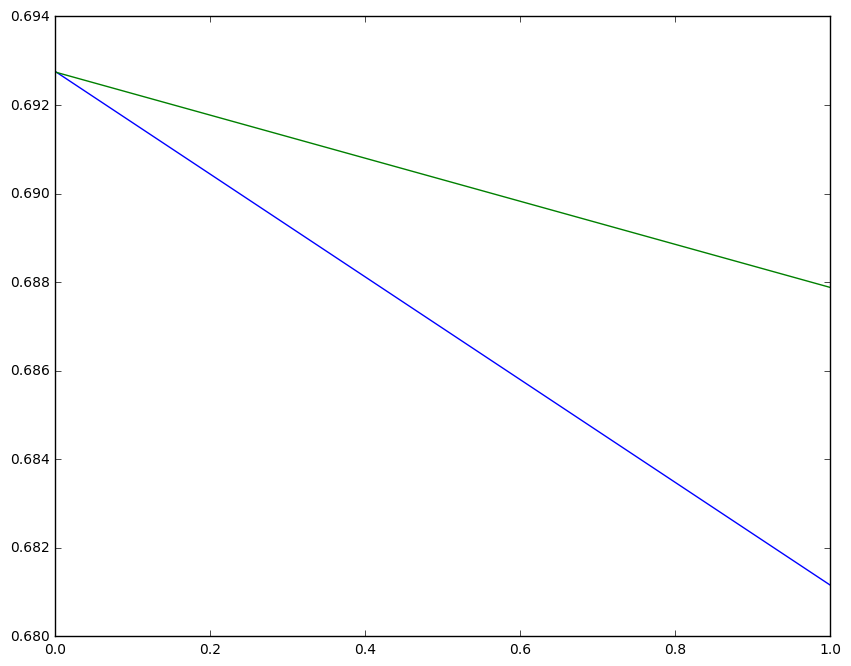

0.916666666667


In [28]:
def generate_data(data, seq_len=50):
    
    chars = list(set(data))
    data_size, vocab_size = len(data), len(chars)
    print 'data has %d characters, %d unique.' % (data_size, vocab_size)
    char_to_ix = { ch:i for i,ch in enumerate(chars) }
    ix_to_char = { i:ch for i,ch in enumerate(chars) }

    d1 = list(data)
    d2 = shuffle_text(d1, 0, len(d1))
    
    l1 = len(d1)/seq_len
    l2 = len(d2)/seq_len
    
    d1.extend(d2)
    
    assert l1 == l2
    
    indices = range(l1+l2)
    random.shuffle(indices)
    
    matrix = np.zeros((l1+l2, seq_len), dtype='int')
    labels = np.zeros(l1+l2, dtype='int')
    
    i = 0
    for k in indices:
        matrix[i, :] = [char_to_ix[c] for c in d1[k:k+seq_len]]
        if k < l1:
            labels[i] = 1
        
        i += 1
    
    p = ((l1+l2)*7)/10
    X_train = matrix[:p,:]
    y_train = labels[:p]
    
    X_test = matrix[p:,:]
    y_test = labels[p:]
    
    return X_train, y_train, X_test, y_test, char_to_ix, ix_to_char, vocab_size

#test for small data, should overfit
data = open('data/warpeace_input.txt','r').read()
data = data[1:500]

X_train, y_train, X_test, y_test, char_to_ix, ix_to_char, vocab_size = generate_data(data)

model = train_model(X_train, y_train, X_test, y_test, vocab_size, 0.0, iters=5, print_every=5, batch_size=50)

print np.mean(model.predict(X_train) == y_train)

In [ ]:
#generate data
data = open('data/warpeace_input.txt','r').read()
X_train, y_train, X_test, y_test, char_to_ix, ix_to_char, vocab_size = generate_data(data, seq_len=10)

model = train_model(X_train, y_train, X_test, y_test, vocab_size, reg=1e-4, iters=10000, print_every=50, batch_size=50)

print np.mean(model.predict(X_train) == y_train)

data has 3258246 characters, 87 unique.
iter 0, loss_train 0.693593, lost_test 0.693084, test accuracy 0.580000
iter 50, loss_train 0.693712, lost_test 0.692993, test accuracy 0.480000
iter 100, loss_train 0.686007, lost_test 0.697583, test accuracy 0.480000
iter 150, loss_train 0.686677, lost_test 0.699450, test accuracy 0.400000
iter 200, loss_train 0.689538, lost_test 0.691734, test accuracy 0.500000
iter 250, loss_train 0.691707, lost_test 0.696070, test accuracy 0.460000
iter 300, loss_train 0.692409, lost_test 0.683190, test accuracy 0.620000
iter 350, loss_train 0.692795, lost_test 0.697235, test accuracy 0.360000
iter 400, loss_train 0.698314, lost_test 0.695459, test accuracy 0.480000
iter 450, loss_train 0.681768, lost_test 0.693683, test accuracy 0.520000
iter 500, loss_train 0.696164, lost_test 0.694206, test accuracy 0.480000
iter 550, loss_train 0.697319, lost_test 0.687900, test accuracy 0.520000
iter 600, loss_train 0.695399, lost_test 0.694578, test accuracy 0.500000
i

In [36]:
z = model.predict(X_test[:500])
print np.mean(z == y_test[:500])

0.994


In [79]:
#default text to work upon
filename = "data/warpeace_input.txt"
t = list('peace')#list(open(filename, 'r').read()[100:200])
i = 0.
cnt = 0.
while i < 100:
    t1 = shuffle_text(t, 0, len(t))
    x1 = np.array([[char_to_ix[c] for c in t]], dtype='int')
    x2 = np.array([[char_to_ix[c] for c in t1]], dtype='int')

    l1 = model.log_entropy_wrt_true(x1)
    l2 = model.log_entropy_wrt_true(x2)
    
    if -l1 <= -l2:
        print ''.join(t1)
    
    cnt += (-l1 > -l2)
    i += 1
    
print cnt/i

pacee
acepe
peeca
ceaep
pceae
ceeap
apeec
eeapc
pecea
ceepa
pacee
capee
cepea
pcaee
pceea
cepea
peeca
eeacp
eceap
cpeea
ceaep
peace
apece
ceepa
ceaep
peace
aceep
cpeea
acepe
eecap
eecap
eapce
peeac
acepe
acepe
eceap
peeca
eecpa
eapce
peeca
pcaee
peeca
ceaep
capee
eapec
0.55


Entropy :  -14.6888521207 , Error :  -1 , Acceptance :  0.676589986468
us  nnl,tsnaoaisy eiaoyeiir ewumtae  fm yi orne rslr d
l 
Entropy :  -12.0116347118 , Error :  -1 , Acceptance :  0.639386189258
ura alsrthoeletrinu
  s eyfwt m fnm
Entropy :  -13.4376100003 , Error :  -1 , Acceptance :  0.613496932515
e oi  rrne fseyi  atlm
unnrtnoaf   mlyf tt
Entropy :  -11.779016248 , Error :  -1 , Acceptance :  0.684931506849
Current state : srio i if ea,o  diadumay dtst'eeereprrtneh,rso
rfyi a 
Entropy :  -13.330289677 , Error :  -1 , Acceptance :  0.582750582751
Current state : e 'moh,sa ttaao ieu s,de roeiiid ipt oo
l rrt tahoswdm nslteiyef tt e
Entropy :  -11.5555514982 , Error :  -1 , Acceptance :  0.599520383693
 lo l nt umfs
e sertfy n iira y pi  drdtdtomoreeewr f she ifhylstn
Entropy :  -10.3527619757 , Error :  -1 , Acceptance :  0.645161290323
Current state :  ttoit ahene   aoymhu tasr  e
thf i a'etfs nidt fmpdf nterrew
Entropy :  -12.3889549962 , Error :  -1 , Acceptance :  0.66312997

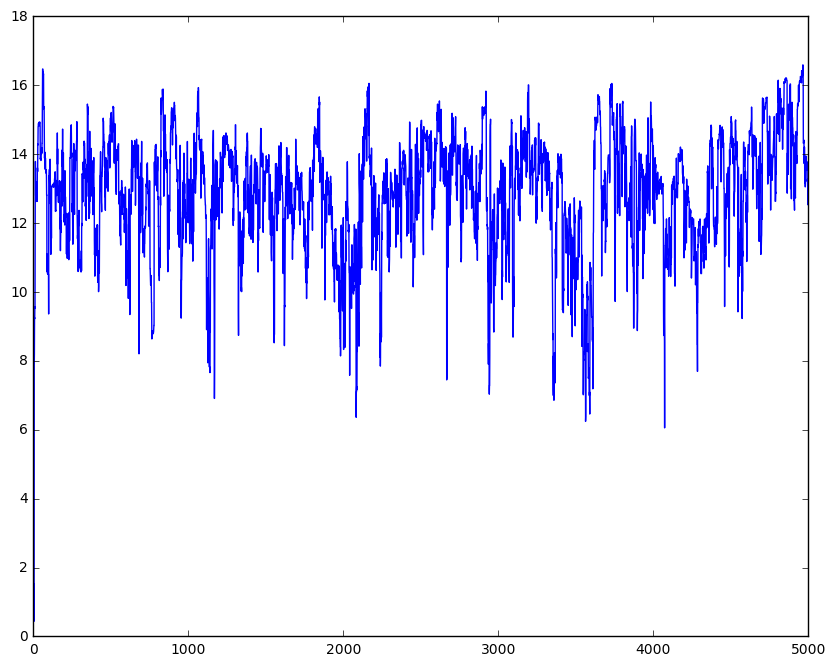

In [65]:
#time to run monte carlo
i = 20

def compute_probability_using_lstm(state):
    x = np.array([[char_to_ix[c] for c in state["text"]]])
    l = model.log_entropy_wrt_true(x)
    return l

def ps(state):
    return ''.join(state["text"])

initial_state = get_state(t1, None, None, char_to_ix, max_len=i)
state, lps, _ = metropolis_hastings(initial_state, propose_a_move, compute_probability_using_lstm, 
                                  iters=5000, print_every=500, tolerance=0.02, pretty_state=ps)

plt.plot(lps)

plt.show()